# [1] Defining the nature and scope of the project

We are given a huge database of more than half a million entry over a few years. Various customer review and food order related information is stored here. We need to seperate and analyze which texts associate mostly with positive and which to negative. For that we will divide the score given by customers into two categories, namely positive and negative. Then it will become a simple binary classification problem where we need to classify based on the bag of words for each sentiment. This project will compare different classifier models with a range of parameters and then pick the best model and parameter based on grid search with cross validation. Finally we will train, predict and evaluate using the best model.

## [2] Importing Necessary Libraries

In [1]:
from time import time
start=time()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import re
from tqdm import tqdm
from nltk.stem import PorterStemmer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## [3] Loading and Exploring Dataset

In [2]:

df = pd.read_csv('Reviews.csv')

In [3]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
df.shape

(568454, 10)

In [6]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## [4] Cleaning Data

In [7]:
df.dropna(inplace=True)

In [8]:
df=df[['Text','Score']].dropna()

In [9]:
df.shape

(568411, 2)

## [5] Preprocessing Data & Visualization

In [10]:
df.Score[df.Score<=3]=0
df.Score[df.Score>=4]=1

In [11]:
positive_review=list(df[df['Score']==1]['Text'])
negative_review=list(df[df['Score']==0]['Text'])

In [12]:
# This segment is needed because

df_pos=df[df['Score']==1][:5000]
df_neg=df[df['Score']==0][:5000]
df=df_pos.append(df_neg)

<AxesSubplot:xlabel='Score', ylabel='count'>

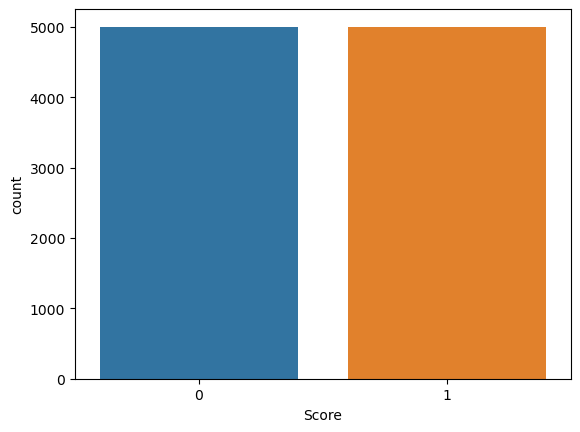

In [13]:
sns.countplot(x='Score',data=df)

In [14]:
df.head(10)

,Text,Score
0,I have bought several of the Vitality canned d...,1
2,This is a confection that has been around a fe...,1
4,Great taffy at a great price. There was a wid...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1
7,This taffy is so good. It is very soft and ch...,1
8,Right now I'm mostly just sprouting this so my...,1
9,This is a very healthy dog food. Good for thei...,1
10,I don't know if it's the cactus or the tequila...,1
11,One of my boys needed to lose some weight and ...,1


In [15]:

def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(10,20))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24})
    plt.show()

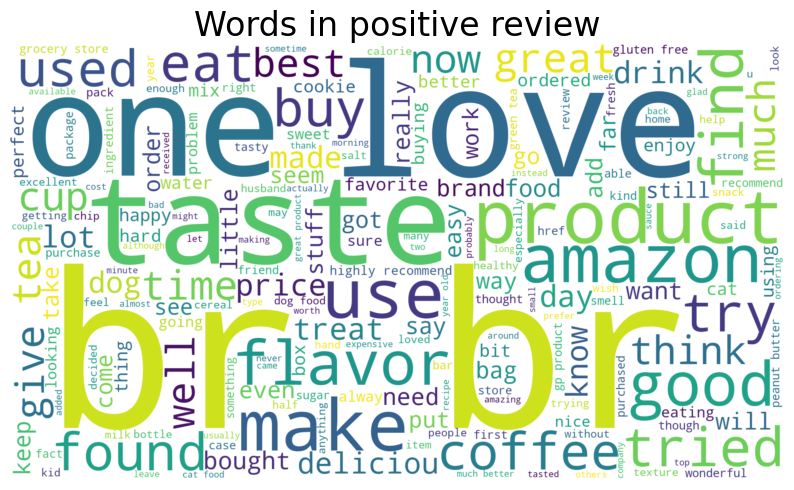

In [16]:
create_cloud(' '.join(positive_review).lower(),'Words in positive review')

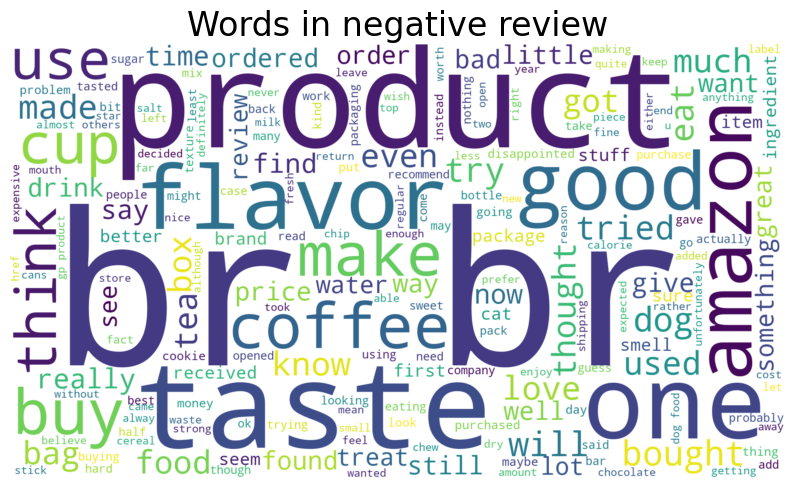

In [17]:
create_cloud(' '.join(negative_review).lower(),'Words in negative review')

In [18]:
def text_processing(data):
    
    def decontracted(phrase):
        # specific
        phrase= re.sub(r'<br /><br />',' ',phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        return phrase
    stopwords=set(STOPWORDS)

    # Combining all the above stundents 
   
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    
    for sentance in tqdm(data['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    

    porter = PorterStemmer()
    list2=[]
    for  sentence in preprocessed_reviews:
      list1=[]
      for words in sentence.split():
        list1.append(porter.stem(words))

      list2.append(' '.join(list1))
    return(list2)

In [19]:
x=text_processing(df)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3312.63it/s]


In [20]:
df['Cleaned_Review']=x
df

,Text,Score,Cleaned_Review
0,I have bought several of the Vitality canned d...,1,i bought sever vital can dog food product foun...
2,This is a confection that has been around a fe...,1,"thi confect around centuries. it light, pillow..."
4,Great taffy at a great price. There was a wid...,1,great taffi great price. there wide assort yum...
5,I got a wild hair for taffy and ordered this f...,1,i got wild hair taffi order five pound bag. th...
6,This saltwater taffy had great flavors and was...,1,thi saltwat taffi great flavor soft chewy. eac...
...,...,...,...
21967,I bought this for my 20lb puppy on the advice ...,0,i bought puppi advic trainer. what disaster! n...
21968,I have a one year old lab mix that we adopted ...,0,i one year old lab mix adopt shelter. got pupp...
21969,This toy is not so good if the treats or kibbl...,0,thi toy good treat kibbl big..... even small k...
21970,Ughh ..l I tried getting a toy for my puppy to...,0,ughh ..l i tri get toy puppi play dispens trea...


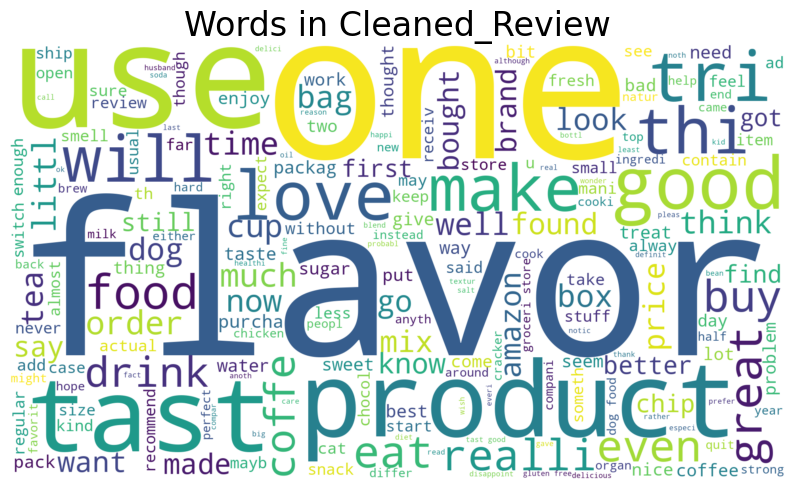

In [21]:
create_cloud(' '.join(x).lower(),'Words in Cleaned_Review')

## [6] Splitting & Vectorizing

In [22]:
score = df['Score']
text = df['Cleaned_Review']
X_train, X_test, y_train, y_test = train_test_split(text, score, test_size=0.25, random_state=19)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500,), (2500,), (7500,), (2500,))

## [7] Vectorizing Data to create Bag of Words

In [24]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# need scaling?

In [25]:
X_train_bow.shape, X_test_bow.shape

((7500, 15684), (2500, 15684))

## [8] Converting vectorized data to array

In [26]:
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

In [27]:
type(X_train_bow), type(X_test_bow), type (y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [28]:
X_train_bow.shape, X_test_bow.shape

((7500, 15684), (2500, 15684))

## [9] Function to compare different models

In [29]:
# List of models to try
models = [KNeighborsClassifier(),
          GaussianNB(),
          LogisticRegression(),
          RandomForestClassifier(),
          DecisionTreeClassifier(),
          GradientBoostingClassifier(),
         ]

# Hyperparameters to try
param_grid = {'KNeighborsClassifier': {'n_neighbors': [10,12,14,16,18,20,22,24,26,28,30]},
              'GaussianNB': {'var_smoothing': [.00001,.0001,.001,0.01,0.1,1,10]},
              'LogisticRegression':{'C': [.00001,.0001,.001,0.01,0.1,1,10]},
              'RandomForestClassifier': {'n_estimators': [100, 200], 'max_depth': [80,90],'max_features': [2, 3]},
              'DecisionTreeClassifier': {'max_depth': [3, 5, 70,85]},
              'GradientBoostingClassifier': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.5, 1]}
             }


# Dataframe to store results
metrics = {'Model': [], 'ATR': [], 'ATS': [], 'F1_TR': [], 'F1_TS': [], 'TIME': [], 'B_P': [],}

# Looping through models
for i, model in enumerate(models):
    mst = time()
    
    # Get model name
    model_name = str(model).replace("()","")
    # model_names.append(model_name)
    # Perform grid search with cross-validation
    gs = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, n_jobs =-1)
    gs.fit(X_train_bow, y_train)
    
    # Get best parameters
    best_params = gs.best_params_
    print(f"Best Paramenters for {model_name} is {best_params}")

    # Fit model with best parameters
    model.set_params(**best_params)
    model.fit(X_train_bow, y_train)
    
    # Append in a list for future use
    # basic_models.append(model)
    
    # Make predictions
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)

    # Calculate metrics
    accuracy_train = accuracy_score(y_pred_train,y_train)
    accuracy_test = accuracy_score(y_pred_test,y_test)
    f1_train=f1_score(y_pred_train,y_train)
    f1_test = f1_score(y_pred_test,y_test)
    
    # Calculate run time for model
    met = time()
    mrt = met-mst
    minute=int(mrt/60)
    second=mrt%60
        
    # Append to DataFrame
    metrics['Model'].append(model_name)    
    metrics['ATR'].append(f"{accuracy_train:.3f}")
    metrics['ATS'].append(f"{accuracy_test:.3f}")
    metrics['F1_TR'].append(f"{f1_train:.3f}")
    metrics['F1_TS'].append(f"{f1_test:.3f}")
    metrics['TIME'].append(f"{mrt:.3f}")
    metrics['B_P'].append(best_params)
    
    metrics_df = pd.DataFrame(metrics)
    

    print(f"{model.__class__.__name__}: accuracy_train={accuracy_train:.4f} accuracy_test={accuracy_test:.4f} f1_train={f1_train:.4f}, f1_test = {f1_test:.4f}")
    
    if minute>=60:
        hour=int(minute/60)
        minute=minute%60
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
    else:
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")
    print()

Best Paramenters for KNeighborsClassifier is {'n_neighbors': 10}
KNeighborsClassifier: accuracy_train=0.6455 accuracy_test=0.6032 f1_train=0.7226, f1_test = 0.7023
Total execution time for KNeighborsClassifier is : 454.4656572341919'.
Which translates to: 7 minutes and 34.466 seconds.

Best Paramenters for GaussianNB is {'var_smoothing': 0.001}
GaussianNB: accuracy_train=0.7601 accuracy_test=0.6692 f1_train=0.8042, f1_test = 0.7432
Total execution time for GaussianNB is : 63.285404682159424'.
Which translates to: 1 minutes and 3.285 seconds.

Best Paramenters for LogisticRegression is {'C': 0.1}
LogisticRegression: accuracy_train=0.9227 accuracy_test=0.8280 f1_train=0.9225, f1_test = 0.8308
Total execution time for LogisticRegression is : 165.22269463539124'.
Which translates to: 2 minutes and 45.223 seconds.

Best Paramenters for RandomForestClassifier is {'max_depth': 80, 'max_features': 3, 'n_estimators': 200}
RandomForestClassifier: accuracy_train=0.9643 accuracy_test=0.7644 f1_tra

## [10] Representing the findings in a table and sorting out the best model with parameters

In [30]:
# Create a PrettyTable object
table = PrettyTable()

# Add columns to the table
table.add_column("Model Name", metrics['Model'])
table.add_column("Accu_train",metrics['ATR'])
table.add_column("Accu_test",metrics['ATS'])
table.add_column("F1_train",metrics['F1_TR'])
table.add_column("F1_test",metrics['F1_TS'])
table.add_column("Time",metrics['TIME'])
table.add_column("Best parameters",metrics['B_P'])

# Set the alignment of the columns
# table.align["Model"] = "l"
# table.align["MAE"] = "r"
# table.align["MSE"] = "r"
# table.align["R2"] = "r"
# table.align["Adjusted R2"] = "r"

print(table)

+----------------------------+------------+-----------+----------+---------+-----------+-----------------------------------------------------------+
|         Model Name         | Accu_train | Accu_test | F1_train | F1_test |    Time   |                      Best parameters                      |
+----------------------------+------------+-----------+----------+---------+-----------+-----------------------------------------------------------+
|    KNeighborsClassifier    |   0.645    |   0.603   |  0.723   |  0.702  |  454.466  |                    {'n_neighbors': 10}                    |
|         GaussianNB         |   0.760    |   0.669   |  0.804   |  0.743  |   63.285  |                  {'var_smoothing': 0.001}                 |
|     LogisticRegression     |   0.923    |   0.828   |  0.922   |  0.831  |  165.223  |                         {'C': 0.1}                        |
|   RandomForestClassifier   |   0.964    |   0.764   |  0.965   |  0.785  |  138.080  | {'max_depth': 80,

In [31]:
best=metrics_df.sort_values(by = ['ATR','F1_TR'], ascending=False).set_index('Model')
print(best)
print()
print(f"Best Model is : \033[1m{best.index[0]}\033[0m with the best parameters : \033[1m{best.iloc[0,-1]}\033[0m")

                              ATR    ATS  F1_TR  F1_TS       TIME  \
Model                                                               
DecisionTreeClassifier      0.974  0.698  0.974  0.700    217.954   
RandomForestClassifier      0.964  0.764  0.965  0.785    138.080   
GradientBoostingClassifier  0.944  0.810  0.944  0.811  18575.249   
LogisticRegression          0.923  0.828  0.922  0.831    165.223   
GaussianNB                  0.760  0.669  0.804  0.743     63.285   
KNeighborsClassifier        0.645  0.603  0.723  0.702    454.466   

                                                                          B_P  
Model                                                                          
DecisionTreeClassifier                                      {'max_depth': 70}  
RandomForestClassifier      {'max_depth': 80, 'max_features': 3, 'n_estima...  
GradientBoostingClassifier        {'learning_rate': 0.5, 'n_estimators': 200}  
LogisticRegression                             

## [11] Finalizing the model with best results

In [32]:
final = DecisionTreeClassifier()
final.set_params(**best.iloc[0,-1])
final.fit(X_train_bow, y_train)

y_pred_train =final.predict(X_train_bow)
y_pred_test = final.predict(X_test_bow)

## [12] Classification Report

In [33]:
y_train.value_counts()

0    3780
1    3720
Name: Score, dtype: int64

In [34]:
print(classification_report(y_pred_train,y_train,target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.99      0.96      0.98      3895
    Positive       0.96      0.99      0.97      3605

    accuracy                           0.97      7500
   macro avg       0.97      0.98      0.97      7500
weighted avg       0.98      0.97      0.97      7500



In [35]:
print(classification_report(y_pred_test,y_test,target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.72      0.68      0.70      1297
    Positive       0.67      0.72      0.69      1203

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



## [13] Confusion Matrix

<AxesSubplot:>

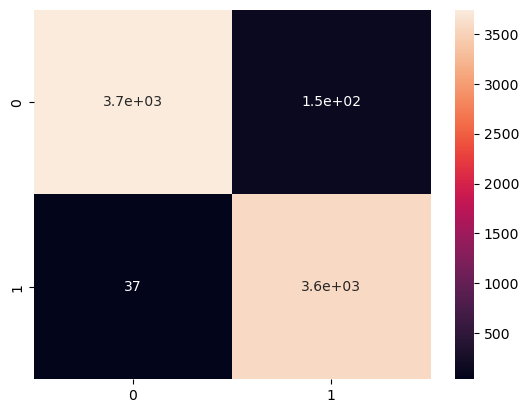

In [36]:
c= confusion_matrix(y_pred_train, y_train)
sns.heatmap(c, annot=True)

<AxesSubplot:>

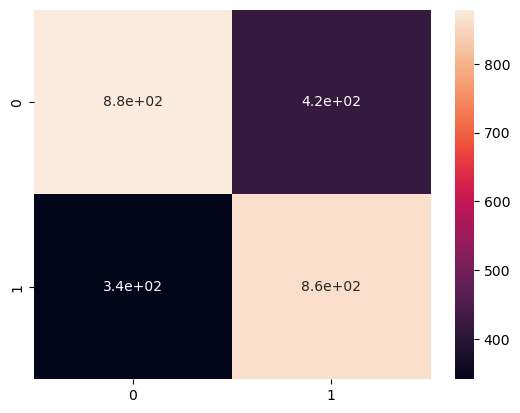

In [37]:
c= confusion_matrix(y_pred_test, y_test)
sns.heatmap(c, annot=True)

## [14] Total Run-time

In [38]:
end=time()
total_time=end-start
minute=int(total_time/60)
second=total_time%60
if minute>=60:
    hour=int(minute/60)
    minute=minute%60
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
else:
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")

Total execution time is : 19782.603372573853
Which translates to: 5 hours 29 minutes and 42.603 seconds.


## [15] Conclusion and Summary

1) The evaluation results show that the DecisionTreeClassifier with parameters {'max_depth': 86} gives the best result for 10000 samples from the given data set.

2) This is big database and GradientBoostingClassifier is much better in terms of result. But it takes a lot of time. So even in such a big database DecisionTreeClassifier or RandomForestClassifier can be a better choice as it gives good enough results but in a much shorter time.